# PyMC3 QP analysis of November 2015 'aftershocks'

## Importing data
Manual pick times are stored for days 329 - 335 inclusive (25-30/11/2015). 

In [1]:
import matplotlib.pyplot as plt
from matplotlib.dates import num2date
from matplotlib.dates import date2num
from matplotlib.dates import DateFormatter
import datetime
import numpy as np
import pymc3 as pm

import theano.tensor as T

%matplotlib inline

Import the pick times

## Fitting the true data
In this scenario, we flipped the data on the x-axis to model an exponential and an inverse Omori law. In reality, we have a true Omori law showing a decaying rate of earthquakes after a given peak. 

This time we know $t_{f}$ as that is our point 0. We still need to define the parameters $k$, $p$ and $c$ as per Omori's law:

$n(t) = k(c+t_{f})^{-p}$

At this stage we're still fitting the logliklihood using a simple Poisson process. To step this up to a gamma point process we need to change that last step. 

Let's first of all prepare our data, this time in chronological order. 

In [2]:
start = date2num(datetime.datetime(1997, 2, 12, 10, 20, 0))
end = date2num(datetime.datetime(1997, 2, 12, 12, 30, 0))

In [3]:
fname='./event_picks.txt'
picks_num = []
with open(fname) as f:
    for line in f:
        if line.rstrip():
            values = line.split('\n')
            pick = float(values[0])
            picks_num.append(pick)
            
print(len(picks_num), 'picks extracted from file')

94 picks extracted from file


In [4]:
picks = np.array(picks_num)-start
print(picks_num[0])
print(start)

dt = 1./24.
freqs, bv = np.histogram(picks, bins=np.arange(0, 6.01, dt))
#for i in range(len(bv)):
#    num2date(bv[i]).replace(tzinfo=None)
#print(bv)
#print(freqs)
ind = np.argmax(freqs)
t_f = bv[ind]
cat = picks[picks>t_f]-t_f
print(t_f)

729067.43234639
729067.4305555555
0.041666666666666664


### Defining the functions
This time we need to use the exponential and modified Omori's law. The data has been imported such that $t_{0} = 0$ and $t$ is time since $t_{0}$ in days. 

In [5]:
# Rate function for modified Omori's law:
def mol_rate(t, params):
    k=params[0]
    c=params[1]
    p=params[2]

    rate = []
    rate = k*((t+c)**-p)
    return(rate)

# Total function for modified Omori's law:
def mol_total(t, t0, params):
    k=params[0]
    c=params[1]
    p=params[2]
    
    total = []
    if p == 1.0:
        total = k*(np.log(c+t) - np.log(c+t0))
    else:
        total = k/(1.-p)*(((c+t)**(1.-p))-((c+t0)**(1.-p)))
    return(total)


# Rate function for exponential model:
def exp_rate(t, params):
    k=params[0]
    lam=params[1]
    
    rate = []
    rate = k*np.exp(-lam*t)
    return(rate)

# Total function for exponential model:
def exp_total(t, t0, params):
    k=params[0]
    lam=params[1]
    
    total = []
    total = (k/-lam)*(np.exp(-lam*t)-np.exp(-lam*t0))
    return(total)


### Initiate the PyMC3 model

In [6]:
t_forc = (picks[-1])
spikes = cat
spikes = spikes[spikes<t_forc]
t_js = np.hstack((0,spikes[:-1]))


In [7]:
mol_model = pm.Model()
with mol_model:
    #k = pm.Uniform('k', lower=250, upper=350)
    #c = pm.Uniform('c', lower=0, upper=8)
    #p = pm.Lognormal('p', mu= 1., tau=5.0)
    
    k = pm.Exponential('k', lam=0.01)
    c = pm.Lognormal('c', mu=0.3, tau=2)
    p = pm.Lognormal('p', mu= 1., tau=5.0)
#    alpha = 1.0
#    alpha = pm.Uniform('alpha', 1.0, 10.0)
    alpha = pm.Exponential('alpha', lam=0.1)

    mol_paras = [k, c, p]
    
    def logl_mol(spikes):
        #Simple Poisson process LL function
#        ll = pm.math.sum(pm.math.log(mol_rate(spikes, mol_paras)) - mol_total(spikes, t_js, mol_paras))
        
#        ll = (pm.math.log(alpha/T.gamma(alpha))
#              + pm.math.sum(pm.math.log(mol_rate(spikes, mol_paras))
#                            +(alpha-1.)*(pm.math.log(alpha)+pm.math.log(mol_total(spikes, t_js, mol_paras)))
#                            +pm.math.log((alpha*mol_total(spikes, t_js, mol_paras))**(alpha-1)+1)
#                            -alpha*mol_total(spikes, t_js, mol_paras)))
                
        pdf = (alpha/T.gamma(alpha) * (mol_rate(spikes, mol_paras))
               * (alpha*mol_total(spikes, t_js, mol_paras))**(alpha-1.)
               * pm.math.exp(-alpha*mol_total(spikes, t_js, mol_paras)))
        
        ll = pm.math.sum(pm.math.log(pdf))
        
        return(ll)
    
    x = pm.DensityDist('x', logl_mol, observed=(spikes))

In [8]:
map_estimate_mol = pm.find_MAP(model=mol_model)
map_paras_mol = np.array([map_estimate_mol['k'], map_estimate_mol['c'], map_estimate_mol['p'], map_estimate_mol['alpha']])
print('MAP estimate for k: ', map_paras_mol[0])
print('MAP estimate for c: ', map_paras_mol[1])
print('MAP estimate for p: ', map_paras_mol[2])
print('MAP estimate for alpha: ', map_paras_mol[3])

logp = 329.46, ||grad|| = 0.39506: 100%|██████████| 35/35 [00:00<00:00, 1745.65it/s]  


MAP estimate for k:  6.606441629186667
MAP estimate for c:  0.23509571756153214
MAP estimate for p:  3.885333716398655
MAP estimate for alpha:  1.487511567236582


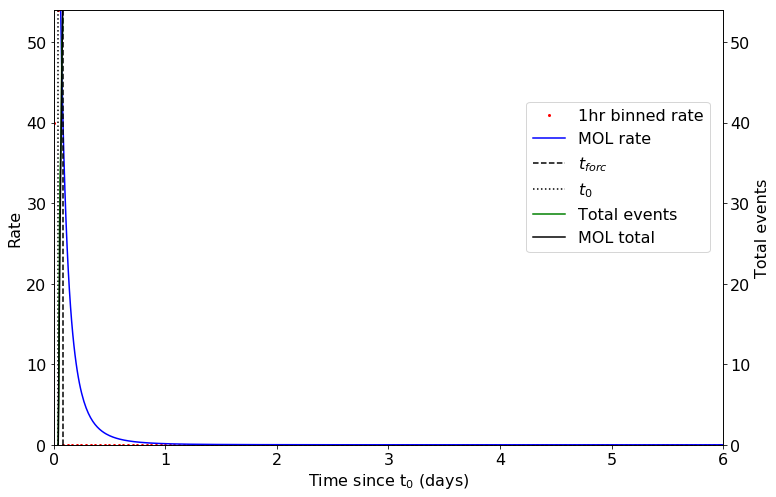

In [9]:
xs = np.arange(0,bv[-1], 0.01)

fig = plt.figure(figsize=(12, 8))
plt.rcParams.update({'font.size':16})
ax1=fig.add_subplot(111)
ax1.plot(bv[:-1], freqs, marker='o', ms=2, mec='r', mfc='r', ls='', label='1hr binned rate')
ax1.plot(xs+t_f, mol_rate(xs, map_paras_mol)*dt, ls='-', c='b', label='MOL rate')

ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_ylabel('Rate')
ax1.set_ylim(0,max(freqs))

ax2 = ax1.twinx()
ax2.plot(cat+t_f, np.arange(len(cat)), color='g', label='Total events')
ax2.plot(xs+t_f, mol_total(xs, 0, map_paras_mol), 'k', label='MOL total')
ax2.yaxis.set_ticks_position('right')
ax2.set_ylabel('Total events')
ax2.set_ylim(0,len(cat))

ax1.set_xlabel('Time since t$_{0}$ (days)')
ax1.set_xlim(0, bv[-1])
ax1.axvline(t_forc, c='k', ls='--', label='$t_{forc}$')
ax1.axvline(t_f, c='k', ls=':', label='$t_{0}$')
fig.legend(loc=2, bbox_to_anchor = (0.6,0.7))

In [10]:
with mol_model:
    trace_mol = pm.sample(5000, chains=1, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [alpha, p, c, k]
Sampling chain 0, 172 divergences: 100%|██████████| 5500/5500 [00:47<00:00, 115.29it/s]
There were 172 divergences after tuning. Increase `target_accept` or reparameterize.
Only one chain was sampled, this makes it impossible to run some convergence checks


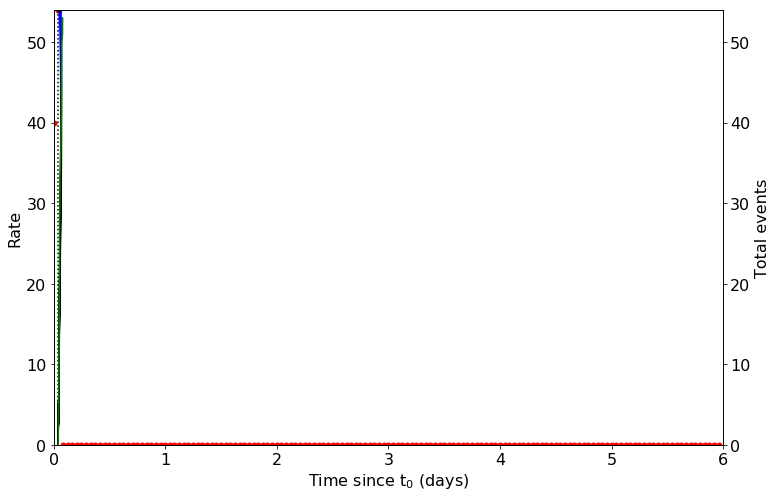

In [11]:
n_bs = 500
xs = np.arange(0, cat[-1], 0.01)

fig = plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size':16})
ax1=fig.add_subplot(111)
ax1.plot(bv[:-1], freqs, marker='o', ms=5, mec='r', mfc='r', ls='', label='1hr binned rate')

for i in np.arange(n_bs):
    samp=int(i*5000/n_bs)
    paras1 = [trace_mol['k'][samp], trace_mol['c'][samp], trace_mol['p'][samp]]
    ax1.plot(xs+t_f, mol_rate(xs, paras1)*dt, 'b', alpha=0.01)
    
ax1.xaxis.set_ticks_position('bottom')
ax1.yaxis.set_ticks_position('left')
ax1.set_ylabel('Rate')
ax1.set_ylim(0,max(freqs))

ax2 = ax1.twinx()


for i in np.arange(n_bs):
    samp=int(i*5000/n_bs)
    paras1 = [trace_mol['k'][samp], trace_mol['c'][samp], trace_mol['p'][samp]]
    ax2.plot(xs+t_f, mol_total(xs, 0, paras1), 'k', alpha=0.01)
ax2.plot(cat+t_f, np.arange(len(cat)), color='g', lw=1.5)
ax2.yaxis.set_ticks_position('right')
ax2.set_ylabel('Total events')
ax2.set_ylim(0,len(cat))

ax1.set_xlabel('Time since t$_{0}$ (days)')
ax1.set_xlim(0, bv[-1])
#ax1.axvline(t_forc, c='k', ls='--', label='$t_{forc}$')
ax1.axvline(t_f, c='k', ls=':', label='$t_{0}$')
#fig.legend(loc=2, bbox_to_anchor = (0.6,0.6))

In [ ]:
pm.plots.traceplot(trace_mol)